# Libraries


In [1]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

# Constants, params


In [2]:
BOARD_SIZE = 16
POPULATION_SIZE = 1000
MUTATION_RATE = 0.1
MAX_GENERATION = 10000

# ChessBoard class (Visualize the Chessboard in 2D array)

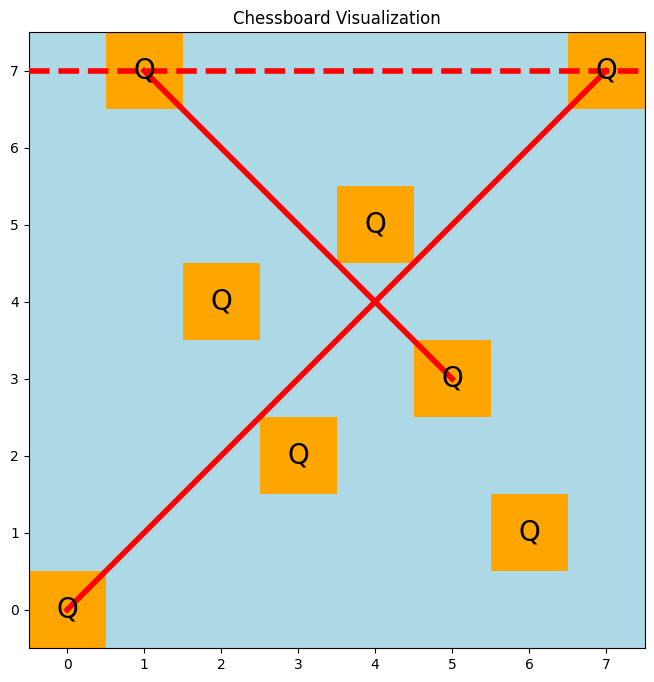

In [3]:
class ChessBoard:
  """ A class to represent a chessboard in 2D array.

  Attributes:
    board_size (int): The size of the chessboard.
    board (numpy.ndarray): A 2D array representing the chessboard.

  Every cell of the initial chessboard will be filled by a dot "."
  And the Queen will be perform by a "Q" after process the `state`.

  """

  def __init__ (self, board_size:int):
    self.board_size = board_size
    self.board = np.full((self.board_size, self.board_size), ".", dtype='<U1')

  def place_queen(self, state):
    self.board.fill(".")
    for col, row in enumerate(state):
      if row >= 0 and row < self.board_size:
        self.board[row, col] = "Q"

  def print_board(self):
    print()
    for row in self.board:
      print(" ".join(row))

  def visualize_chessboard(self):
    plt.figure(figsize=(self.board_size, self.board_size))

    color_map = np.where(self.board == "Q", 1, 0)

    cmap = plt.cm.colors.ListedColormap(['lightblue', 'orange'])
    plt.imshow(color_map, cmap=cmap, interpolation='nearest')

    plt.xticks(ticks=np.arange(self.board_size), labels=np.arange(self.board_size))
    plt.yticks(ticks=np.arange(self.board_size), labels=np.arange(self.board_size))

    for row in range(self.board_size):
      for col in range(self.board_size):
        if self.board[row, col] == "Q":
            plt.text(col, row, 'Q', ha='center', va='center', fontsize=20, color='black', zorder=10)

    # Show main and anti diagonal grid
    # for start in range(self.board_size):
    #     plt.plot([start, self.board_size - 1], [0, self.board_size - 1 - start], color='blue', linewidth=1, zorder=5)
    #     plt.plot([start, 0], [self.board_size - 1, self.board_size - 1 - start], color='blue', linewidth=1, zorder=5)
    #     plt.plot([start, 0], [0, start], color='blue', linewidth=1, zorder=5)
    #     plt.plot([start, self.board_size - 1], [self.board_size - 1, start], color='blue', linewidth=1, zorder=5)

    queens_positions = [(row, col) for row in range(self.board_size) for col in range(self.board_size) if self.board[row, col] == "Q"]

    attacking_rows = set()
    attacking_cols = set()

    for i in range(len(queens_positions)):
      for j in range(i + 1, len(queens_positions)):
        row1, col1 = queens_positions[i]
        row2, col2 = queens_positions[j]

        if abs(row1 - row2) == abs(col1 - col2):
          if row1 < row2:
            plt.plot([col1, col2], [row1, row2], color='red', linewidth=4, zorder=5)
          else:
            plt.plot([col1, col2], [row1, row2], color='blue', linewidth=4, zorder=5)

        if row1 == row2:
          attacking_rows.add(row1)
        if col1 == col2:
          attacking_cols.add(col1)

    for row in attacking_rows:
      plt.axhline(y=row, color='red', linewidth=4, linestyle='--', zorder=4)

    for col in attacking_cols:
      plt.axvline(x=col, color='red', linewidth=4, linestyle='--', zorder=4)

    plt.title("Chessboard Visualization")
    plt.gca().invert_yaxis()
    plt.show()

if __name__ == "__main__":
    board_size = 8
    chessboard = ChessBoard(board_size)
    example_state = [0, 7, 4, 2, 5, 3, 1, 7]
    chessboard.place_queen(example_state)
    chessboard.visualize_chessboard()

# State class (Visualize the Chess board in 1D array)

## For example:
- We have a 4x4 Chess board below (Index of colum and row both start from 0):
    ```
    3 . . . Q
    2 Q . . .
    1 . Q . .
    0 . . Q .
    \ 0 1 2 3
    ```
It will be visualized: `[2, 1, 0, 3]`
- That means, `col[0]` have a Queen placed at `row[2]` -> `queen[0][2]` and so on ...

In [4]:
class State:
  """ A class to represent a state of a chessboard.

  Attributes:
    board_size (int): The size of the chessboard.
    state (list): A list of integers representing the row positions of queens.
    maximum_non_attacking_pairs (int): The maximum number of non-attacking pairs of queens.
    fitness_score (int): The fitness score of the state.
    selection_prob (float): The selection probability of the state.
    length (int): The length of the state
  """

  def __init__(self, board_size:int, random_state:bool):
    self.board_size = board_size
    self.state = []
    self.maximum_non_attacking_pairs = self.board_size * (self.board_size - 1) // 2
    self.selection_prob = None

    if random_state:
      self.state = [random.randint(0, self.board_size - 1) for _ in range(0, self.board_size)]
      self.fitness_score = self.calculate_fitness()
      self.length = self.get_state_length()

  def set_state(self, state):
    self.state = state
    self.fitness_score = self.calculate_fitness()
    self.length = self.get_state_length()

  def get_state(self):
    return self.state

  def set_selection_prob(self, selection_prob):
    self.selection_prob = selection_prob

  def get_selection_prob(self):
    return self.selection_prob

  def get_fitness(self):
    return self.fitness_score

  def calculate_fitness(self): # O(n)
    number_of_queen_in_each_column = [0] * (self.board_size)

    # For a chessboard size of N * N, there will be 2 * (2 * N - 1) diagonal from both side
    number_of_queen_in_main_diagonal = [0] * (2 * self.board_size - 1)  # From -(n - 1) to (n - 1)
    number_of_queen_in_anti_diagonal = [0] * (2 * self.board_size - 1)  # From 0 to (2n - 2)

    for row in range(self.board_size):
      col = self.state[row]
      number_of_queen_in_each_column[col] += 1
      number_of_queen_in_main_diagonal[row - col + (self.board_size - 1)] += 1
      number_of_queen_in_anti_diagonal[row + col] += 1

    attacking_pairs = 0

    for count in number_of_queen_in_each_column:
      if count > 1:
        attacking_pairs += count * (count - 1) // 2

    for count in number_of_queen_in_main_diagonal:
      if count > 1:
        attacking_pairs += count * (count - 1) // 2

    for count in number_of_queen_in_anti_diagonal:
      if count > 1:
        attacking_pairs += count

    return self.maximum_non_attacking_pairs - attacking_pairs

  def mutate_state(self, position: int, value: int):
    self.state[position - 1] = value
    self.fitness_score = self.calculate_fitness()

  def get_state_length(self):
    return __builtins__.len(self.state)

  def to_table(self, table_name:str):
    print(f"{table_name.upper()}")
    print(f"{'State':<65} {'Length':<15} {'Fitness Score':<15}")
    print("=" * 100)
    print(f"{str(self.get_state()):<67} {self.get_state_length(): <18} {self.get_fitness():<18}")

# Testing State class and ChessBoard class


SOLUTION
State                                                             Length          Fitness Score  
[1, 4, 8, 14, 4, 10, 10, 6, 0, 0, 8, 8, 2, 15, 6, 1]                16                 107               


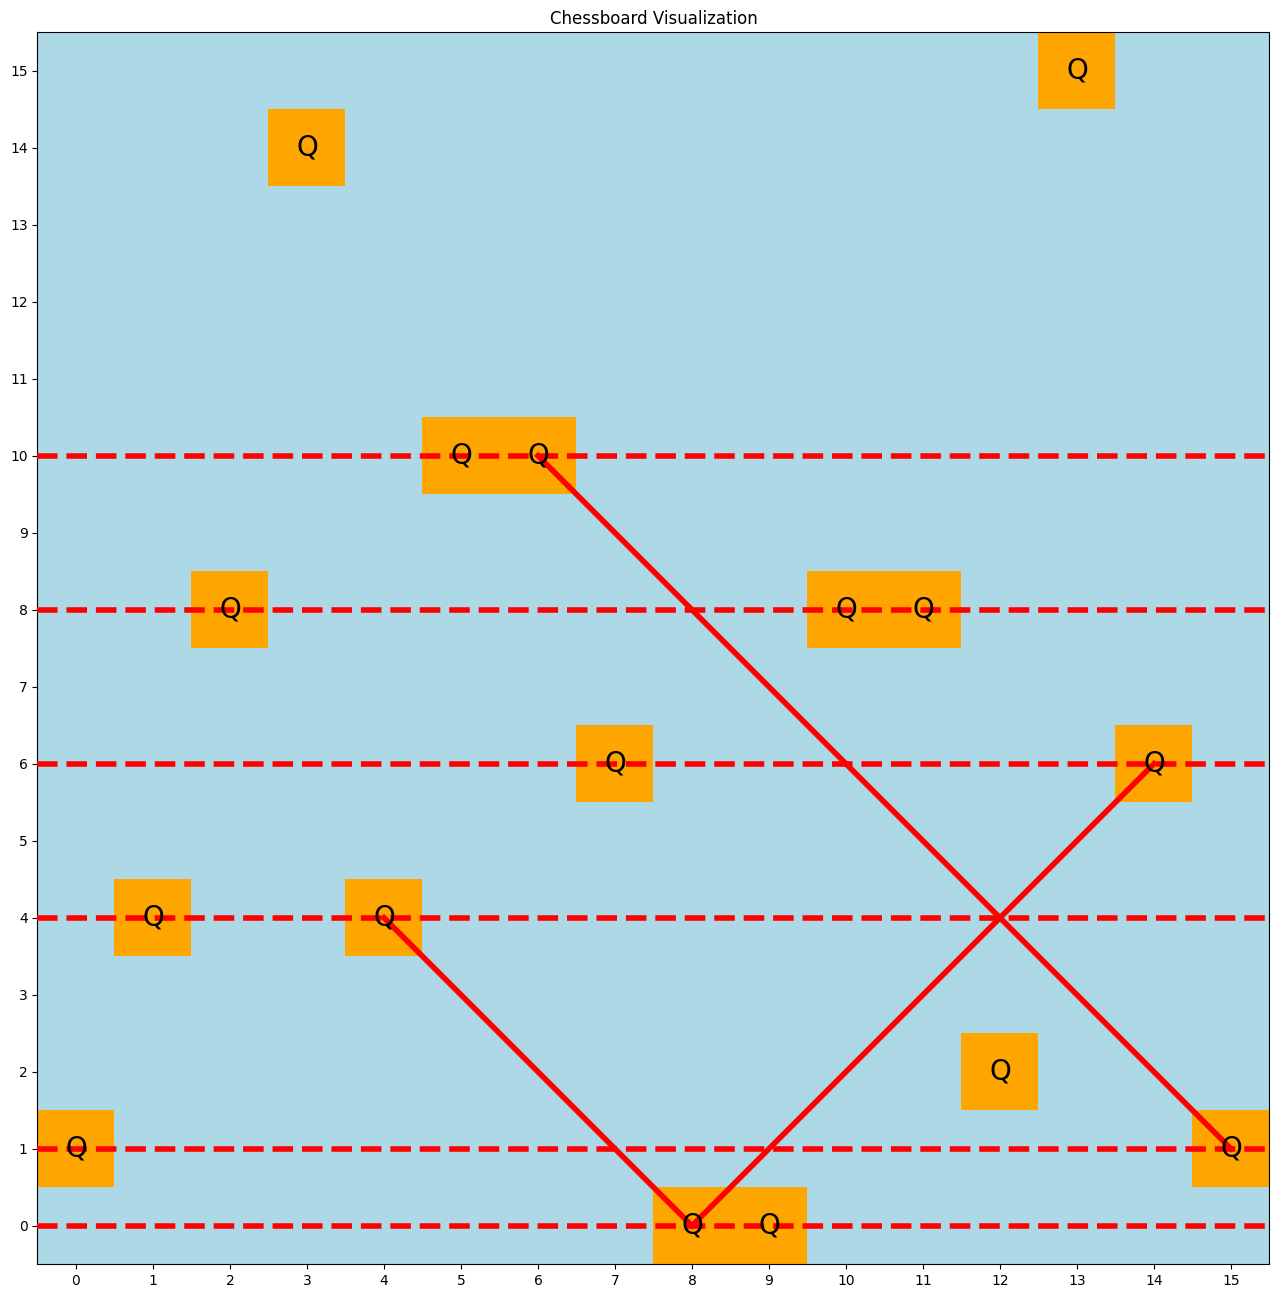

In [5]:
if __name__ == "__main__":
  state_obj = State(board_size=BOARD_SIZE, random_state=False)
  state_obj.set_state([1, 4, 8, 14, 4, 10, 10, 6, 0, 0, 8, 8, 2, 15, 6, 1])
  state_obj.to_table("\nSolution")

  chess_board_obj = ChessBoard(board_size=16)
  chess_board_obj.place_queen(state_obj.get_state())
  # chess_board_obj.print_board()
  chess_board_obj.visualize_chessboard()


# GeneticAlgorithm class

In [ ]:
class Population:
  def __init__(self, board_size:int, population_size:int, mutation_rate:float, none_population: bool):
    self.board_size = board_size
    self.population_size = population_size
    self.mutation_rate = mutation_rate
    if none_population:
      self.population = []
    else:
      self.population = self.generate_population()

    self.max_fitness = self.calculate_max_fitness()
    self.selection_prob = self.set_selection_prob_for_all_state()

  def add_new_state_to_population(self, state):
    self.population.append(state)

  def generate_population(self):
    return [State(self.board_size, random_state=True) for _ in range(self.population_size)]

  def print_population(self):
    for state in self.population:
      print(f"{str(state.get_state()):<70} {state.get_fitness():<18}")

  def get_population(self):
    return self.population

  def get_population_length(self):
    return __builtins__.len(self.population)

  def set_selection_prob_for_all_state(self):
    total_fitness = sum(state.get_fitness() for state in self.population)
    selection_probs = []
    for state in self.population:
      selection_prob = state.get_fitness() / total_fitness
      state.set_selection_prob(selection_prob)
      selection_probs.append(selection_prob)

    return selection_probs

  def evaluate_population(self):
    self.population.sort(key=lambda state: state.get_fitness(), reverse=True)
    self.population = self.population[:-1]

  def make_couples(self):
    if (len(self.population) % 2) != 0:
      self.population.append(self.population[0])

  def population_pop(self, pos:int):
    self.population.pop(pos)

  def crossover_two_state(self, parent1, parent2):
    crossover_start_point = random.randint(1, self.board_size - 3)
    crossover_end_point = random.randint(crossover_start_point + 1, self.board_size - 1)

    allele1 = parent1.get_state()[crossover_start_point:crossover_end_point]
    allele3 = parent2.get_state()[crossover_start_point:crossover_end_point]

    allele2 = parent2.get_state().copy()
    for num in allele1:
      for i in allele2:
        if num == i:
          allele2.remove(i)
          break

    allele2 = allele2

    allele4 = parent1.get_state().copy()
    for num in allele3:
      for i in allele4:
        if num == i:
          allele4.remove(i)
          break

    allele4 = allele4

    tmp1 = __builtins__.len(allele1) + __builtins__.len(allele2)
    tmp2 = __builtins__.len(allele3) + __builtins__.len(allele4)

    if tmp1 == 16:
      child1 = allele2[:crossover_start_point] + allele1 + allele2[crossover_start_point:]
    else:
      child_end_point = -(abs(BOARD_SIZE - tmp1))
      child1 = allele2[:crossover_start_point] + allele1 + allele2[crossover_start_point:child_end_point]

    if tmp2 == 16:
      child2 = allele4[:crossover_start_point] + allele3 + allele4[crossover_start_point:]
    else:
      child_end_point = -(abs(BOARD_SIZE - tmp2))
      child2 = allele4[:crossover_start_point] + allele3 + allele4[crossover_start_point:child_end_point]

    child1_state = State(self.board_size, random_state=False)
    child1_state.set_state(child1)

    child2_state = State(self.board_size, random_state=False)
    child2_state.set_state(child2)

    return child1_state, child2_state

  def crossover_population(self):
    for i in range(0, len(self.population), 2):
      parent1 = self.population[i]
      parent2 = self.population[i + 1]
      child1, child2 = self.crossover_two_state(parent1, parent2)

      self.population[i] = child1
      self.population[i + 1] = child2

  def mutation(self):
    for state in self.population:
        if random.random() < self.mutation_rate:
            random_position = random.randint(0, self.board_size - 1)
            random_value = random.randint(0, self.board_size - 1)
            state.mutate_state(random_position, random_value)

  def calculate_max_fitness(self):
    max_fitness = 0
    for state in self.population:
      if state.get_fitness() > max_fitness:
        max_fitness = state.get_fitness()
    return max_fitness

  def get_state_max_fitness(self):
    for state in self.population:
      if state.get_fitness() == self.max_fitness:
        return state

  def get_max_fitness(self):
    self.max_fitness = self.calculate_max_fitness()
    return self.max_fitness

  def to_table(self, table_name:str):
    print(f"{table_name.upper()} (Length = {self.get_population_length()})")
    print("=" * 103)
    print(f"{'State':<65} {'Fitness Score':<15} {'Selection Probability' :<15}")
    print("=" * 103)
    for state in self.population:
      print(f"{str(state.get_state()):<70} {state.get_fitness():<17} {state.get_selection_prob():.4f}")

if __name__ == "__main__":
  start_time = time.time()
  current_generation = Population(board_size=BOARD_SIZE, population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, none_population=False)
  current_generation.to_table("\nInitial Population")

  loop = 0

  def run(current_generation):
    global loop

    while loop < MAX_GENERATION:
      print(f"LOOP: {loop} / {MAX_GENERATION} ", end="")
      current_generation.evaluate_population()
      current_generation.set_selection_prob_for_all_state()
      # current_generation.to_table("\nAfter evaluation")
      current_generation.make_couples()
      current_generation.set_selection_prob_for_all_state()
      # current_generation.to_table("\nAfter make couple")
      current_generation.crossover_population()
      current_generation.set_selection_prob_for_all_state()
      # current_generation.to_table("\nAfter crossover")
      current_generation.mutation()
      current_generation.set_selection_prob_for_all_state()
      # current_generation.to_table("\nAfter mutation")

      print(f"--> Max fitness: {current_generation.get_max_fitness()}")

      if current_generation.get_max_fitness() == 120:
        print(f"\n🟢🟢🟢 SOLUTION FOUND at loop {loop} / {MAX_GENERATION}")
        solution = State(board_size=BOARD_SIZE, random_state=False)
        solution = current_generation.get_state_max_fitness()
        solution.to_table("\n")

        chess_board_obj = ChessBoard(board_size=BOARD_SIZE)
        chess_board_obj.place_queen(solution.get_state())
        # chess_board_obj.print_board()
        chess_board_obj.visualize_chessboard()

        return
      loop += 1

    print("🔴🔴🔴 No solution found after {loop} loop")

  run(current_generation=current_generation)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTime taken to find the solution: {elapsed_time:.2f} seconds")


INITIAL POPULATION (Length = 1000)
State                                                             Fitness Score   Selection Probability
[0, 4, 2, 14, 13, 10, 0, 0, 14, 1, 13, 11, 13, 13, 10, 6]              98                0.0010
[10, 15, 7, 4, 12, 15, 9, 8, 5, 3, 12, 11, 7, 6, 11, 0]                104               0.0010
[9, 12, 6, 4, 3, 5, 13, 8, 0, 3, 14, 12, 13, 12, 3, 1]                 99                0.0010
[1, 5, 1, 14, 13, 2, 9, 3, 11, 9, 11, 13, 15, 15, 12, 6]               106               0.0011
[2, 12, 8, 10, 9, 1, 5, 4, 11, 8, 4, 7, 12, 1, 9, 7]                   105               0.0010
[13, 10, 11, 5, 12, 4, 12, 4, 2, 7, 10, 6, 9, 9, 14, 9]                104               0.0010
[10, 1, 2, 11, 12, 9, 8, 11, 7, 12, 0, 12, 2, 11, 0, 6]                99                0.0010
[0, 5, 12, 5, 1, 8, 8, 3, 6, 2, 14, 2, 9, 4, 14, 11]                   105               0.0010
[1, 5, 13, 15, 9, 1, 11, 0, 10, 10, 9, 13, 12, 13, 12, 1]              97                0.0